## 시작하기 전에     

#### 이 노드의 목표      

   1. 텍스트용 데이터를 수치 데이터로 변환하는 과정을 이해한다.   
   2. RNN에 대해 알아본다.         
   3. 시퀀셜한 데이터를 다루는 방법을 이해한다.      
   4. 1-D CNN에 대해 알아보고, 이를 이용하여 텍스트를 처리한다.       
   5. IMDB와 네이버 영화리뷰 데이터셋을 이용하여 감성분류를 수행한다.

#### 1. 텍스트 데이터의 특징        

1) 텍스트 감성분석의 기법     
* 기계학습 기반의 접근법
* 감성사전 기반 접근법   

2) __워드 임베딩 기법__ ex)word2Vec using CNN, LSTM   
  * 단어의 특성을 저차원 벡터값으로 표현하는 기법.    
  * 단어의 의미가 유사할 경우 벡터 공간상에 가깝게 배치해 단어 간의 어휘적 관계를 벡터로 표현하는 방법.
  * 라벨링 비용을 절감하면서, 정확도를 크게 향상시킬 수 있다.     
  
3) 텍스트 데이터를 어떻게 숫자로 바꿔보지?    

    > "텍스트를 어떻게 숫자 행렬로 표현할 것인가?"
    > "텍스트의 입력 순서를 어떻게 인공지능에 반영해주는가?"

#### 2. 텍스트를 숫자 행렬로 표현하는 법

In [1]:
sentences = ['I feel pretty', 'I really miss you', 'Have a nice day']

word_list = 'I feel pretty'.split()
print(word_list)

['I', 'feel', 'pretty']


In [2]:
#모든 문장을 단어 단위로 쪼개어 딕셔너리로 표현하기

index_to_word = {}

index_to_word[0]='<PAD>'
index_to_word[1]='<BOS>'
index_to_word[2]='<UNK>'
index_to_word[3]='I'
index_to_word[4]='feel'
index_to_word[5]='pretty'
index_to_word[6]='Have'
index_to_word[7]='a'
index_to_word[8]='nice'
index_to_word[9]='day'

print(index_to_word)


{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: 'I', 4: 'feel', 5: 'pretty', 6: 'Have', 7: 'a', 8: 'nice', 9: 'day'}


In [6]:
#텍스트 데이터를 숫자로 바꾸려면, 단어(키):숫자(밸류) 구조여야 하므로 딕셔너리를 뒤집어보자.

word_to_index={word:index for index, word in index_to_word.items()}
print(word_to_index)

{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, 'I': 3, 'feel': 4, 'pretty': 5, 'Have': 6, 'a': 7, 'nice': 8, 'day': 9}


In [48]:
#문장을 입력하면, 단어 인덱스 리스트로 변환하는 함수
#인공지능 입력을 위해 모든 문장은 'BOS'로 시작해야한다.

def get_changed_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 위의 목록에서 수동으로 word_to_index에 넣어준 'Have a nice day' 가 숫자로 변환되어 존재함을 알 수 있다.
print(get_changed_sentence('Have a nice day', word_to_index))

[1, 2, 6, 327, 251]


In [12]:
#확장 ver(여러개의 문자를 적용시켜 보자)

def get_changed_sentences(sentences, word_to_index):
    return [get_changed_sentence(sentence, word_to_index) for sentence in sentences]

#기존에 sentences에 있던 문장들이 변환되어 존재함을 알 수 있음.
#'I feel pretty', 'I really miss you', 'Have a nice day'
#공통적으로 들어간 1(<BOS>) 말고 기존에 있었던 애들은 숫자 그대로, 없었던 애(really miss you)는 2로 통일되어 나오는 것을 알수있다.
#왜 그럴까?
changed_sentences = get_changed_sentences(sentences, word_to_index)
print(changed_sentences)

[[1, 3, 4, 5], [1, 3, 2, 2, 2], [1, 6, 7, 8, 9]]


In [15]:
#반대로, 숫자처리된 자료들을 다시 텍스트로 변환하는 함수도 만들어놓자.
def get_back_sentence(changed_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in changed_sentence[1:])

#2로 변환된 really miss you는 처리가 안된다!
print(get_back_sentence([1,3,2,2,2], index_to_word))
print(get_back_sentence([1,6,7,8,9], index_to_word))

I <UNK> <UNK> <UNK>
Have a nice day


In [17]:
#이번엔 숫자처리된 자료들을 텍스트(들)로 변환하는 확장ver.
def get_back_sentences(changed_sentences, index_to_word):
    return [get_back_sentence(changed_sentence, index_to_word) for changed_sentence in changed_sentences]

print(get_back_sentences(changed_sentences, index_to_word))

['I feel pretty', 'I <UNK> <UNK> <UNK>', 'Have a nice day']


#### 3. 임베딩 레이어        

> 단순히 텍스트를 숫자로 대치하는 것 뿐만이 아니라, '텍스트 간의 상관관계'를 알 수 있어야 한다.    

- 단어의 의미를 나타내는 벡터를 '파라미터'로 놓고 딥러닝이 이를 학습한다.
- Tensorflow, Pytorch에는 이러한 의미 벡터들을 담아놓은 임베딩 레이어를 제공해준다.    


 __임베딩 레이어 사용상의 주의사항__    
 
 * 임베딩 레이어의 인풋 문장은 __길이가 일정해야 한다.__      
 * 임베딩 레이어에 집어넣을 때는 텐서플로우의 'keras.preprocessing.sequence.pad_sequence' 를 통해 <PAD> 를 주고 가자.    

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = len(word_to_index)
print("word_to_index 길이 : ", vocab_size)

#단어가 4차원 워드벡터로 이루어질 것으로 가정
word_vector_dimension = 4

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dimension, mask_zero=True)

#raw_inputs를 말해주고,
raw_inputs=np.array(get_changed_sentences(sentences, word_to_index))

#프리프로세싱.시퀀스.패드시퀀스를 통해 길이를 패딩으로 맞춰줌
#첫 센텐스의 마지막 부분이 0인 것을 알 수 있음
raw_inputs = keras.preprocessing.sequence.pad_sequences(raw_inputs, value=word_to_index['<PAD>'], padding='post', maxlen=5)

print(raw_inputs)

#센텐스가 워드 벡터로 임베딩되어 output으로 나온다는 것을 알 수 있음
output=embedding(raw_inputs)
print(output)
print("\n output's shape : ", output.shape)

word_to_index 길이 :  10
[[1 3 4 5 0]
 [1 3 2 2 2]
 [1 6 7 8 9]]
tf.Tensor(
[[[-0.03051151  0.02841732 -0.03729496 -0.02859491]
  [ 0.0024193   0.03932982  0.00559451  0.0408089 ]
  [ 0.04109034 -0.04591468 -0.03560702 -0.01259921]
  [-0.03085756 -0.01416973  0.01689265  0.04038281]
  [ 0.02616055 -0.02782708  0.0316637   0.04122571]]

 [[-0.03051151  0.02841732 -0.03729496 -0.02859491]
  [ 0.0024193   0.03932982  0.00559451  0.0408089 ]
  [ 0.01436741 -0.04632701 -0.04413111 -0.0402706 ]
  [ 0.01436741 -0.04632701 -0.04413111 -0.0402706 ]
  [ 0.01436741 -0.04632701 -0.04413111 -0.0402706 ]]

 [[-0.03051151  0.02841732 -0.03729496 -0.02859491]
  [ 0.04573134  0.04993096 -0.04990758 -0.03642692]
  [-0.00891285 -0.02764868  0.0483343  -0.01335718]
  [-0.02255197  0.00026774  0.00019399 -0.02052029]
  [-0.0233076   0.00730736  0.03960934  0.04454095]]], shape=(3, 5, 4), dtype=float32)

 output's shape :  (3, 5, 4)


/home/ssac23/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


* output shape의 (3,5,4)는 각각     
* 입력 문장의 개수, 입력 문장의 최대 길이, 워드벡터의 차원 수이다.

#### 시퀀스를 다루는 RNN      

1) RNN의 특징    
    - RNN(Recurrent Neural Network)/ recurrent:되풀이
    - 텍스트 데이터, 음성 데이터와 같은 시퀀스 데이터를 처리하기에 좋다.
    - 시퀀스 데이터? => 입력이 시간을 따라 발생하는 데이터.
    - 나 오늘 ~했는데 그래서~ => 그 뒤를 아무도 예측할 수 없다!      
  ---
   - RNN은 이것에 대비해 __시간의 흐름에 따라 새롭게 변하는 데이터를 묘사하는 state machine으로 설계되었다__    
    > state vs stateless
    > state : 이전의 상태가 저장되어 다음의 입력에 영향을 미친다.   
    > stateless : 이전 상태는 전혀 저장되지 않아 매번 새롭게 처음부터 끝까지 입력해줘야 한다.

2) RNN을 사용한 텍스트 데이터 처리

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

voca_size =10
word_vector_dimension=4

model = keras.Sequential()
model.add(keras.layers.Embedding(voca_size, word_vector_dimension, input_shape=(None,)))

#아까 많이 쓰인다고 했던 바로 그 레이어! LSTM
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


#### 아니, 근데 그러면 RNN만 되나?      __NOPE__     

- 1-D CNN을 사용할 수도 있다.(이미지에는 2D CNN을 썼지만, 텍스트는 한줄로 들어오는 자료이므로 1D CNN)   
- 1-D CNN은 문장 전체를 한꺼번에 길이 7짜리의 필터로 스캐닝하여 7단어 이내에서 특징을 추출하여 문장 분류   
- CNN은 RNN보다 병렬처리를 효율적으로 수행하므로, 학습 속도가 빠르게 진행된다!

#### 1-D CNN을 구현해보자.

In [27]:
voca_size = 10
word_vector_dim = 4

model = keras.Sequential()
model.add(keras.layers.Embedding(voca_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16,7,activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16,7,activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8,activation='relu'))
model.add(keras.layers.Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          464       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

__이 수많은 레이어 중 GlobalMaxPooling1D()만 써도 의외로 긍정적인 효과가 있을 수 있다!__ 고 한다   
- 이 방법은 전체 문장 중 가장 중요한 한 단어만 추출하여 긍/부정을 판단하는 방식

In [28]:
voca_size = 10
word_vector_dim = 4

model = keras.Sequential()
model.add(keras.layers.Embedding(voca_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8,activation='relu'))
model.add(keras.layers.Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


이 외에도,     

> - 1-D CNN을 RNN레이어와 섞어 쓰거나,    
> - FFN(FeedForwardNetwork)레이어만으로 구성하거나,      
> - Transformer 레이어를 쓰는 등 

다양한 해결책을 찾을 수 있다. 

#### IMDB 영화 리뷰 감성분석 해보기       

- IMDB Large Movie Dataset : 50,000개의 영어로 작성된 영화 리뷰 텍스트    
- 긍정:1, 부정:0    
- 훈련 데이터:25,000, 평가 데이터:25,000

In [30]:
#데이터 다운로드 및 전처리 시퀀스

import tensorflow as tf
from tensorflow import keras
import numpy as np

print(tf.__version__)
imdb = keras.datasets.imdb

#num_words=10,000 옵션을 통해, 10,000개의 word_to_index 딕셔너리가 생성된 형태로 데이터가 다운된다.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

2.2.0
훈련 샘플 개수: 25000, 테스트 개수: 25000


In [32]:
#1번째 리뷰데이터는 218개의 단어로 이루어져 있으며, 
#결과는 1이므로 긍정 리뷰임을 알 수 있음
print(x_train[0]) 
print('라벨: ', y_train[0])  
print('1번째 리뷰 문장 길이: ', len(x_train[0]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218


In [44]:
#텐서플로우 사용 가이드에 따라, 인코더 함수와 디코더 함수를 좀 수정한다.

word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}

#디코더 함수를 수정하기 전에는 1:the 였다는 것을 기억하자.
print(index_to_word[1])     # 'the'  
print(word_to_index['the'])  # 1 

#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2 
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

#위에서 함수를 수정하며 '세 칸 밀렸기 때문에' 4:the가 되었다.
print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['the'])  # 4 이 출력됩니다. 
print(index_to_word[4])     # 'the' 가 출력됩니다.

the
1
<BOS>
4
the


In [50]:
#수정한 디코더가 제대로 작동하는지 확인해보자
print(get_changed_sentence(x_train[5], index_to_word))
print('라벨: ', y_train[5])  # 1번째 리뷰데이터의 라벨

KeyError: '<BOS>'

#### 잊지 말아야 할 것     
   * __pad_sequences__ 를 통해 데이터의 문장 길이를 통일해야 한다.
   * 문장 최대 길이를 정하는 __maxlen__ 도 모델 성능에 영향을 미치기 때문에,    
   * 전체 데이터셋의 길이 분포를 확인하여 가장 적절한 길이를 적용해주는 것이 좋다.

In [52]:
total_data_text = list(x_train) + list(x_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


   * 또, 패딩을 앞/뒤에 적용하는 __pre, post padding__ 도 모델의 성능에 영향을 미친다.     
   * Pre padding이 좋음. 왜? >>     
   * RNN은 입력 데이터가 순차적으로 적용되므로, 뒤로 갈 수록 state에 미치는 영향이 커지기 때문.    
   * 따라서 뒤쪽 부분이 padding이 될 경우 비효율적이며, pre-padding을 적용하는 것이 좋다.  

In [53]:
#Pre-padding과 Post-padding의 차이를 적용할 때는 요렇게! 
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


## 2. 분석 실습하기

1. 훈련을 시행하기 전에, 훈련 데이터셋을 훈련+검증 셋으로 나누어준다.

In [54]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


### 2-1. RNN모델 적용하기

In [55]:

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 20 에포크 훈련시킨 후, 5에포크를 기점으로 성능에 큰 변화가 없다는 것을 알 수 있었다.               
epochs=5  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
30/30 [==============================] - 2s 59ms/step - loss: 0.6931 - accuracy: 0.5060 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 2/5
30/30 [==============================] - 1s 47ms/step - loss: 0.6930 - accuracy: 0.5124 - val_loss: 0.6931 - val_accuracy: 0.5007
Epoch 3/5
30/30 [==============================] - 1s 49ms/step - loss: 0.6925 - accuracy: 0.5120 - val_loss: 0.6929 - val_accuracy: 0.5007
Epoch 4/5
30/30 [==============================] - 1s 47ms/step - loss: 0.6919 - accuracy: 0.5126 - val_loss: 0.6923 - val_accuracy: 0.5016
Epoch 5/5
30/30 [==============================] - 1s 47ms/step - loss: 0.6890 - accuracy: 0.5059 - val_loss: 0.6908 - val_accuracy: 0.5044


In [59]:
results = model.evaluate(x_test, y_test, verbose=2)

print(results)

782/782 - 7s - loss: 0.6910 - accuracy: 0.5070
[0.6909895539283752, 0.5070000290870667]


In [60]:
# history 변수를 통해 epoch마다 발생한 수치들을 확인해 볼 수 있다.
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


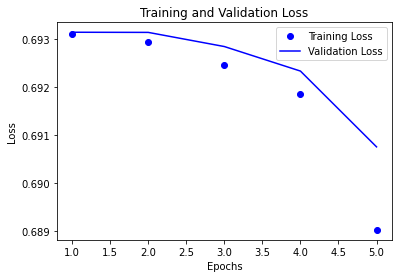

In [64]:
#위의 히스토리를 그래프로 그려보자

import matplotlib.pyplot as plt

accu = history_dict['accuracy']
value_accu = history_dict['val_accuracy']

loss = history_dict['loss']
value_loss = history_dict['val_loss']

epochs = range(1, len(accu)+1)

# bo와 b는 각각 파란 점선, 파란 선
plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, value_loss, 'b', label = 'Validation Loss')

#그래프 주석(타이틀, x축, y축)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.show()

> 그래프를 그려 확인할 때, validation loss와 training loss 의 차이가 커지면 트레이닝이 무의미해진다.   

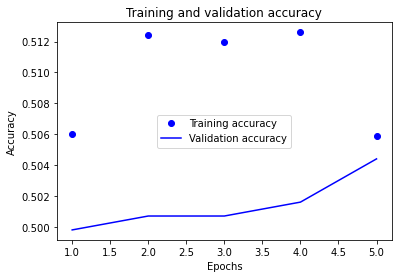

In [66]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, accu, 'bo', label='Training accuracy')
plt.plot(epochs, value_accu, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 2-3. 워드 임베딩 기법과 Word2Vec

   * 우리는 Enbedding 레이어를 통해 10,000개의 크기를 가진 파라미터를 학습시켰다.    
   * gensim 패키지를 설치하여 몇 가지를 확인

In [67]:
# 아까 옵션을 주어 10,000 길이를 다운로드 받았다.
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    

(10000, 16)


In [68]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장 
word2vec_file_path = os.getenv('HOME')+'/SUBMIT_MISSION_GIT/ex4_Text/word2vec.txt'
f = open(word2vec_file_path, 'w')

#몇 개, 얼마만큼의 사이즈를 적용할 것인지
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [69]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

# Computer라는 단어를 읽어 해당 단어의 워드 벡터를 보여준다.
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

array([-0.0216671 , -0.04035783, -0.02801956,  0.01957939, -0.02708866,
        0.04285479, -0.04346569,  0.00972694,  0.00131848,  0.00091889,
       -0.0238007 , -0.03882904, -0.02587099,  0.04241561,  0.02553775,
       -0.0223966 ], dtype=float32)

In [70]:
#기학습된 데이터 중 'love'와 비슷한 게 있을까?
word_vectors.similar_by_word("love")

[('terrific', 0.8653486967086792),
 ('subtle', 0.8570706844329834),
 ('shred', 0.8505549430847168),
 ('persons', 0.827022135257721),
 ('liberty', 0.8180781602859497),
 ('favourite', 0.8018106818199158),
 ('actor', 0.7980704307556152),
 ('goers', 0.7953050136566162),
 ('animated', 0.7910274863243103),
 ('reality', 0.7894230484962463)]

#### 전이학습과 Word2Vec     

* 왜 중요한가?    
> Word2Vec과 같은 사전학습된 모델은 '이전에 학습된 데이터를 누적시켜 적용' 할 수 있기 때문에, 제로베이스에서 시작하는 다른 모델보다 정확도가 높게 나올 확률이 크다.    

In [72]:
#word2vec를 가져와서 동일한 'computer'의 워드벡터를 확인해보자.
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/SUBMIT_MISSION_GIT/ex4_Text/W2V/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [73]:
#word2vec를 사용하니, 아까보다는 결과값이 좀 더 'love'와 가까워진 것을 확인할 수 있다.
word2vec.similar_by_word("love")

[('loved', 0.6907792091369629),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100709438323975),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547305345535278),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

### 사전준비

In [74]:
# 10,000개의 단어
vocab_size = 10000 
# 워드 벡터의 차원수(변경가능, Word2Vec 설명에 300개의 차원수라고 기재되어 있었음)
word_vector_dim = 300  

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

### 모델의 변경 및 적용

In [75]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    
word_vector_dim = 300  

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix), 
                                 input_length=maxlen, 
                                 trainable=True))  
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 580, 300)          3000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 574, 16)           33616     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 114, 16)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 108, 16)           1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

### 학습 진행

In [76]:

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
30/30 [==============================] - 21s 700ms/step - loss: 0.6817 - accuracy: 0.5570 - val_loss: 0.6646 - val_accuracy: 0.6033
Epoch 2/5
30/30 [==============================] - 9s 301ms/step - loss: 0.6189 - accuracy: 0.6801 - val_loss: 0.5681 - val_accuracy: 0.7381
Epoch 3/5
30/30 [==============================] - 9s 300ms/step - loss: 0.4627 - accuracy: 0.8108 - val_loss: 0.4019 - val_accuracy: 0.8263
Epoch 4/5
30/30 [==============================] - 9s 298ms/step - loss: 0.3213 - accuracy: 0.8674 - val_loss: 0.3245 - val_accuracy: 0.8635
Epoch 5/5
30/30 [==============================] - 9s 300ms/step - loss: 0.2315 - accuracy: 0.9137 - val_loss: 0.2966 - val_accuracy: 0.8750


In [77]:
#모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 10s - loss: 0.3088 - accuracy: 0.8692
[0.30877816677093506, 0.8692399859428406]


> 아까 단순히 테스트했던 정확도(0.50대)에서, 많이 향상된 것을 확인할 수 있다. (정확도 +0.3)

#### 그럼 이제 '한국어 감성분석 실습'을 진행해보자.